# Introduction

This notebook presents a comprehensive preprocessing and exploratory analysis of a financial transaction dataset, with the objective of preparing data for machine learning–based money laundering detection.

The workflow includes:
- Feature engineering to capture transaction behavior
- Normalization and encoding of numerical and categorical variables
- Graph-based feature generation using account-level transaction networks
- Temporal and statistical feature extraction
- Visual analysis of class imbalance and correlation structure
- Time series visualization of transaction volume

The processed dataset and insights gained from this notebook will serve as the foundation for building and evaluating predictive models capable of identifying illicit financial activity.


In [43]:
import pandas as pd 
import numpy as np 
import os

df = pd.read_csv('../data/LI-Small_Trans_Orig.csv')
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:08,11,8000ECA90,11,8000ECA90,3195403.00,US Dollar,3195403.00,US Dollar,Reinvestment,0
1,2022/09/01 00:21,3402,80021DAD0,3402,80021DAD0,1858.96,US Dollar,1858.96,US Dollar,Reinvestment,0
2,2022/09/01 00:00,11,8000ECA90,1120,8006AA910,592571.00,US Dollar,592571.00,US Dollar,Cheque,0
3,2022/09/01 00:16,3814,8006AD080,3814,8006AD080,12.32,US Dollar,12.32,US Dollar,Reinvestment,0
4,2022/09/01 00:00,20,8006AD530,20,8006AD530,2941.56,US Dollar,2941.56,US Dollar,Reinvestment,0


# Initial Data Exploration and Cleaning

Basic dataset inspection was conducted to understand structure, data types, and summary statistics. Missing values were checked and removed to ensure data integrity.

- Renamed columns for clarity and consistency.
- Dropped rows with missing values.
- Used `.info()` and `.describe()` to examine dataset shape, types, and distributions.

These steps ensure a clean starting point for further analysis and feature engineering.


In [ ]:
# Getting to know the data
df.info()
print(df.describe())
# Checking for missing values
print(df.isnull().sum())

# Renaming columns for easier handling
df.columns = [
    'timestamp', 'from_bank', 'from_account', 'to_bank', 'to_account',
    'amount_received', 'receiving_currency', 'amount_paid', 'payment_currency',
    'payment_format', 'is_laundering'
]
# Dropping unnecessary columns
df = df.dropna() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6924049 entries, 0 to 6924048
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 581.1+ MB
          From Bank       To Bank  Amount Received   Amount Paid  \
count  6.924049e+06  6.924049e+06     6.924049e+06  6.924049e+06   
mean   5.938718e+04  8.441702e+04     6.324067e+06  4.676036e+06   
std    9.051700e+04  9.064562e+04     2.105371e+09  1.544099e+09   
min    0.000000e+00  0.000000e+00     1.000000e-06  1.000000e-06   
25%    2.190000e+02  1.125500e+04     1.742100e+02  1.

In [ ]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Total Amount Received Over Time

A time series plot was generated by aggregating `amount_received` on a daily basis. This helps visualize transaction volume trends and detect any unusual spikes or drops over time.


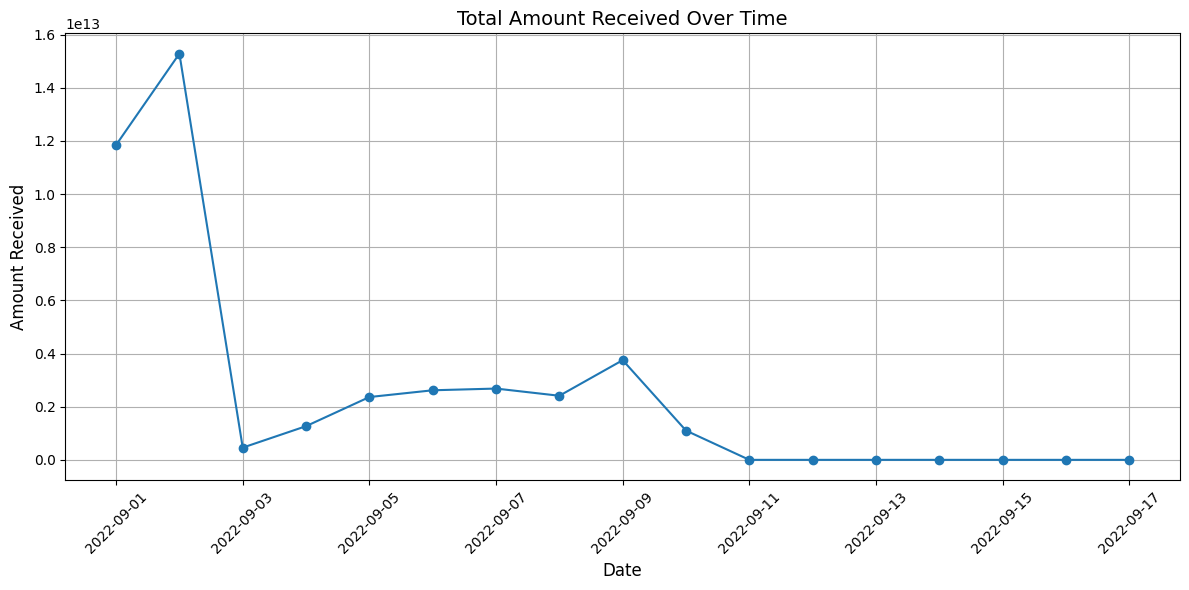

In [46]:
# Total money Received over time
# Group the timestamp for smoother plot 
df_daily = df.groupby(df['timestamp'].dt.date)['amount_received'].sum()

plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily.values, marker='o', linestyle='-')
plt.title('Total Amount Received Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Amount Received', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

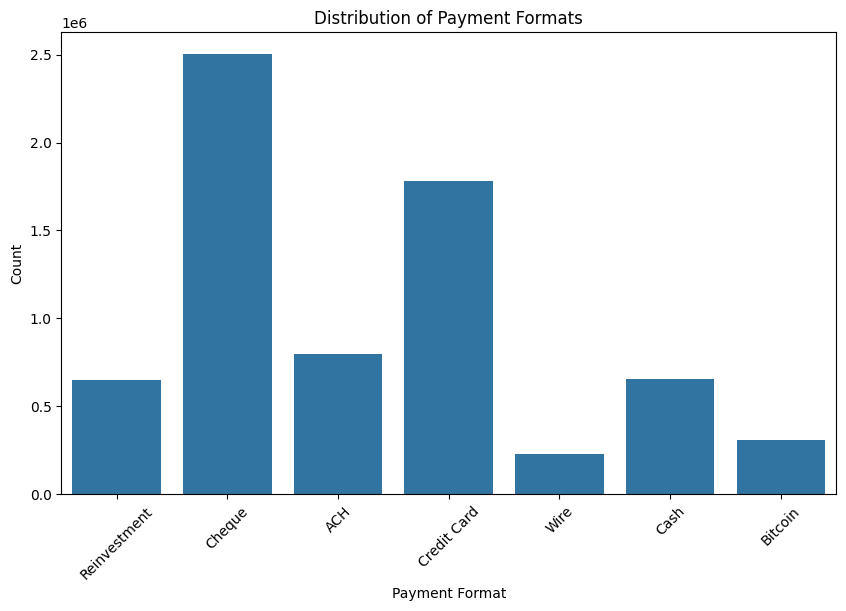

In [47]:
# Plotting the distribution of amounts received
plt.figure(figsize=(10, 6))
sns.countplot(x='payment_format', data=df)
plt.title('Distribution of Payment Formats')
plt.xlabel('Payment Format')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Laundering Class Distribution

The dataset shows a severe class imbalance, with 6,920,484 non-laundering transactions and only 3,565 laundering cases. This highlights the need for resampling techniques during model training.

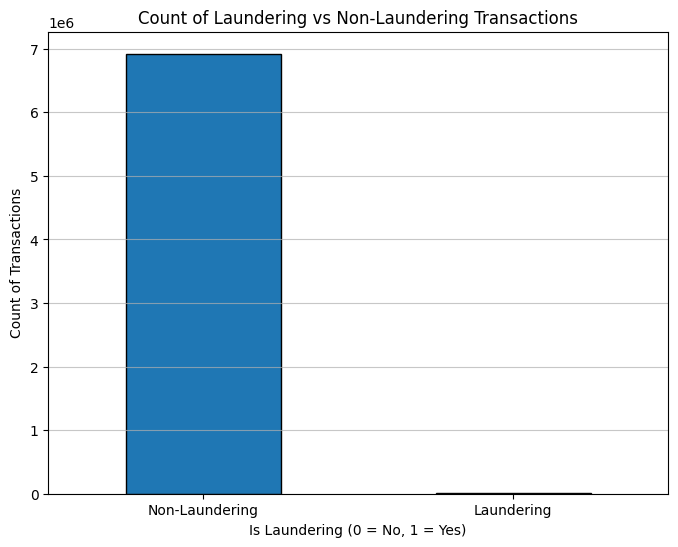

is_laundering
0    6920484
1       3565
Name: count, dtype: int64


In [48]:
# Count the occurrences of each category
laundering_counts = df['is_laundering'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
laundering_counts.plot(kind='bar', edgecolor='black')

plt.title('Count of Laundering vs Non-Laundering Transactions')
plt.xlabel('Is Laundering (0 = No, 1 = Yes)')
plt.ylabel('Count of Transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Laundering', 'Laundering'], rotation=0)
plt.grid(axis='y', alpha=0.7)
plt.show()

# Exact values 
laundering_counts = df['is_laundering'].value_counts()
print(laundering_counts)

# Correlation Matrix

A Pearson correlation matrix was computed to examine linear relationships between numerical features. The heatmap shows a strong positive correlation (0.74) between `amount_paid` and `amount_received`, while most other features, including `is_laundering`, show weak or no correlation.

This suggests potential independence among features and indicates that laundering behavior may not be linearly associated with raw transaction values.

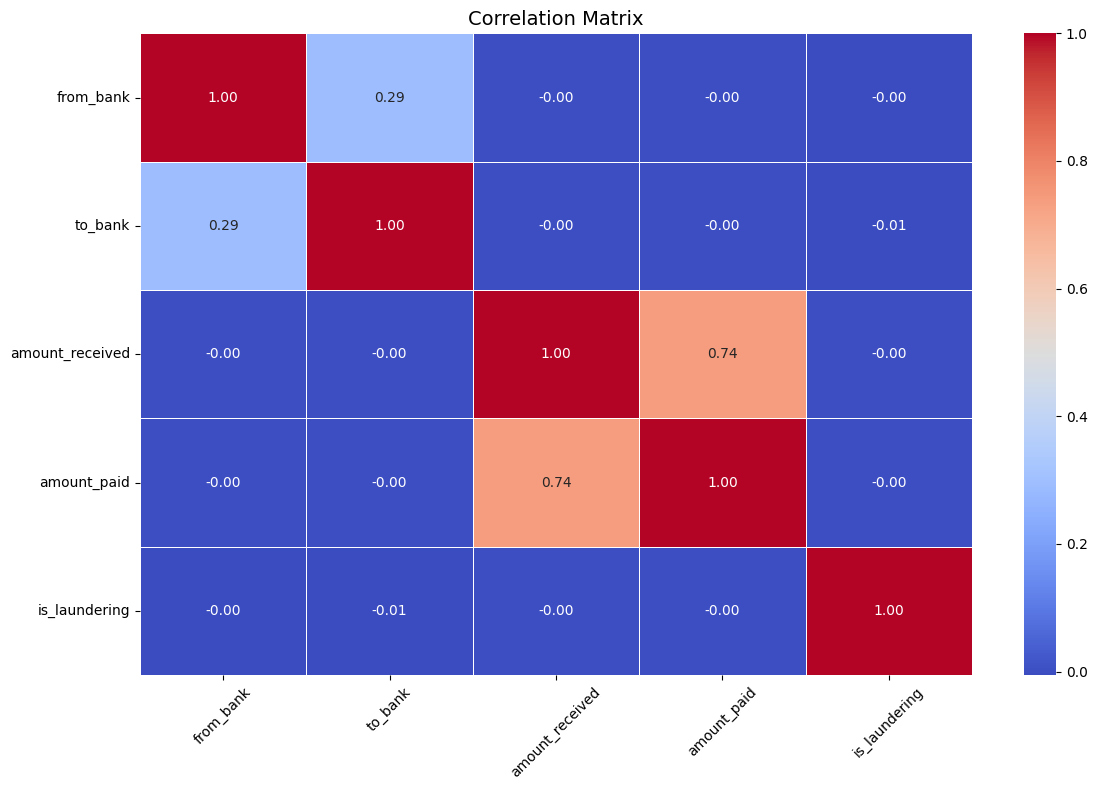

In [49]:
# Correlation matrix
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Transaction Data Preprocessing Overview

This pipeline prepares raw financial transaction data for machine learning by engineering behavioral, temporal, and structural features, ensuring readiness for fraud or anomaly detection tasks.

## Methodology

- **Feature Engineering**: 
  - Derived `amount_diff` as the net transfer (`amount_paid - amount_received`).
  - Computed sender-level aggregates: transaction count, total sent, average amount.
  - Added `unique_receivers` per sender to capture interaction diversity.

- **Normalization**: 
  - Scaled `amount_paid`, `amount_received`, and `amount_diff` using Min-Max normalization.

- **Temporal Features**:
  - Extracted `hour_of_day` and `day_of_week` from timestamps.

- **Categorical Encoding**:
  - Applied one-hot encoding to `payment_format`, `payment_currency`, and `receiving_currency`.

- **Graph Features**:
  - Constructed a directed graph with `from_account` → `to_account` edges using NetworkX.
  - Extracted `in_degree`, `out_degree`, and `PageRank` to quantify account-level influence and activity.

- **Finalization**:
  - Removed identifiers (`timestamp`, account/bank fields) to reduce redundancy and avoid data leakage.
  - Optionally saved the cleaned dataset for modeling.

## Technologies Used

- **Python**, **Pandas** – data manipulation  
- **Scikit-learn** – feature scaling  
- **NetworkX** – graph construction and metrics

This structured approach ensures the dataset captures transactional patterns and user-network behavior essential for downstream predictive modeling.


In [ ]:
# Preprocessing Part 
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

# Amount difference(sent VS received)
df['amount_diff'] = df['amount_paid'] - df['amount_received']

# Normalizing columns
scaler = MinMaxScaler()
df[['amount_received', 'amount_paid', 'amount_diff']] = scaler.fit_transform(
    df[['amount_received', 'amount_paid', 'amount_diff']]
)
# Add sender focused stats(transaction count, total sent, and average amount per sender)
sender_stats = df.groupby('from_account')['amount_paid'].agg(['count', 'sum', 'mean']).reset_index()
sender_stats.columns = ['from_account', 'txn_count', 'total_sent', 'avg_txn_amount']
df = df.merge(sender_stats, on='from_account', how='left')

# Unique receivers per sender
unique_receivers = df.groupby('from_account')['to_account'].nunique().reset_index(name='unique_receivers')
df = df.merge(unique_receivers, on='from_account', how='left')

# Time-based features(Have high impact SHAP)
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# One-hot encoding(Binary rncoding for categorical features)
df = pd.get_dummies(df, columns=['payment_format', 'payment_currency', 'receiving_currency'], drop_first=True)

# For graph-based features
G = nx.from_pandas_edgelist(df, source='from_account', target='to_account', create_using=nx.DiGraph())
df['out_degree'] = df['from_account'].map(dict(G.out_degree())).fillna(0)
df['in_degree'] = df['to_account'].map(dict(G.in_degree())).fillna(0)
df['pagerank'] = df['from_account'].map(nx.pagerank(G)).fillna(0)

final_df = df.drop(columns=['timestamp', 'from_bank', 'to_bank', 'from_account', 'to_account'])

# Save preprocessed dataset
# final_df.to_csv('../data/processed_transactions.csv', index=False)
# print("Preprocessing complete. Saved to '../data/processed_transactions.csv'")

Preprocessing complete. Saved to '../data/processed_transactions.csv'
